# Estudio de la evolución de la pandemia por el modelo de red neuronal recurrente para la isla de La Gomera

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    #plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.legend()
    plt.show()
    
def visualizar_historico(train, y_test, y_pred, variable, dias_historico, indices, tit, color, dif):
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color_isla)
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    plt.bar(indices, dif, width=0.5, color='black', alpha=0.2, align='edge', label='Diferencia')
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.2))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    historico = modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32, verbose=2)
    
    return modelo, historico
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_resultados_texto(y_test, y_pred, fechas):
    for i in range(len(y_test)):
        print(str(fechas[i]) + ': número de casos reales ' + str(int(y_test[i][0])) + ', número de casos predichos ' + str(y_pred[i][0]))
        
def visualizar_perdida(historico):
    plt.plot(historico.history['loss'], label='train')
    plt.plot(historico.history['val_loss'], label='test')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.title('Pérdida del modelo')
    plt.legend()
    plt.show() 

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_LaGomera = datos[datos['isla'] == 'LA GOMERA']

datos_LaGomera = datos_LaGomera.set_index('fecha') # Asignamos la fecha como índice

In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a predecir y a agrupar para cada predicción
isla = 'La Gomera'         # Isla a la que se está realziando el estudio
fechas = datos_LaGomera.tail(dias_prediccion).index # Fechas de los días a predecir
color_isla = 'olive' # Color de la isla en las visualizaciones
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train

variables_covid = [objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']    # Atributos para el análisis de las variables pandémicas
variables_atm = [objetivo, 'tmin', 'tmed', 'presMax']                            # Atributos para el análisis de las variables atmosféricas
variables = [objetivo,'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables


In [5]:
# Cargamos los datos de cada estudio con sus atributos correspondientes
datos_LaGomera_uni = datos_LaGomera[objetivo]
datos_LaGomera_uni_arr = np.array(datos_LaGomera_uni).reshape(-1, 1)

datos_LaGomera_mult_covid = datos_LaGomera[variables_covid]
datos_LaGomera_mult_atm = datos_LaGomera[variables_atm]
datos_LaGomera_mult_total = datos_LaGomera[variables]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_uni_scaled = scaler.fit_transform(datos_LaGomera_uni_arr)

In [7]:
n_train = len(datos_LaGomera_uni_scaled) - dias_prediccion


train = datos_LaGomera_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaGomera_uni_scaled[n_train - dias_prediccion:len(datos_LaGomera_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0535 - val_loss: 0.1838 - 3s/epoch - 214ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0488 - val_loss: 0.1752 - 124ms/epoch - 9ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0447 - val_loss: 0.1552 - 120ms/epoch - 9ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0403 - val_loss: 0.1274 - 120ms/epoch - 9ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0350 - val_loss: 0.0962 - 119ms/epoch - 8ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0283 - val_loss: 0.0721 - 119ms/epoch - 8ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0264 - val_loss: 0.0702 - 121ms/epoch - 9ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0260 - val_loss: 0.0702 - 119ms/epoch - 9ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0246 - val_loss: 0.0685 - 120ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0223 - val_loss: 0.0678 - 120ms/epoch - 9ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0221 - val_loss: 0.0657 - 119ms/epoch - 8ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0211 - val_loss: 0.0656 - 119ms/epoch - 8ms/step
Epoch 13/40
14/14 - 0s - l

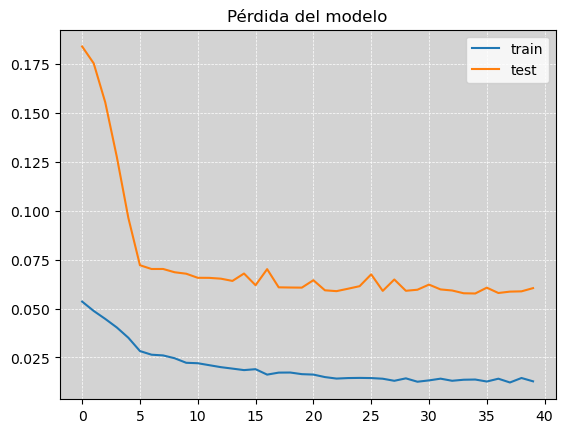

In [10]:
visualizar_perdida(historico)

In [11]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 321ms/step


In [12]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 12, número de casos predichos 27.320917
2022-03-20: número de casos reales 7, número de casos predichos 27.51061
2022-03-21: número de casos reales 53, número de casos predichos 26.847006
2022-03-22: número de casos reales 36, número de casos predichos 27.15612
2022-03-23: número de casos reales 32, número de casos predichos 27.614729
2022-03-24: número de casos reales 32, número de casos predichos 28.745697
2022-03-25: número de casos reales 27, número de casos predichos 26.90675
2022-03-26: número de casos reales 13, número de casos predichos 26.826273
2022-03-27: número de casos reales 14, número de casos predichos 25.623259
2022-03-28: número de casos reales 13, número de casos predichos 25.162607


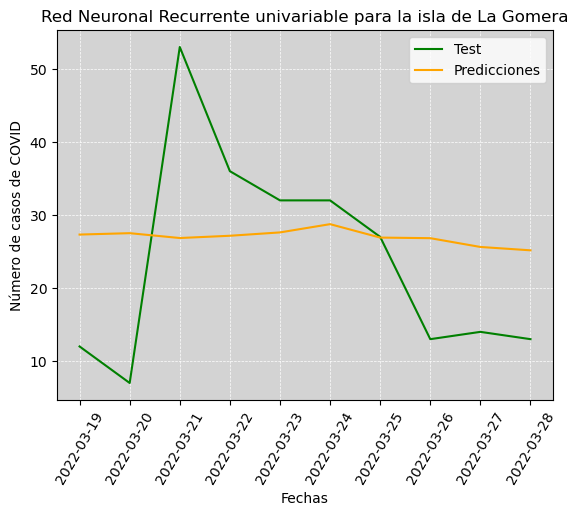

In [13]:
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [14]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-15.32091713, -20.51061058,  26.15299416,   8.8438797 ,
         4.38527107,   3.25430298,   0.09325027, -13.82627296,
       -11.62325859, -12.16260719])

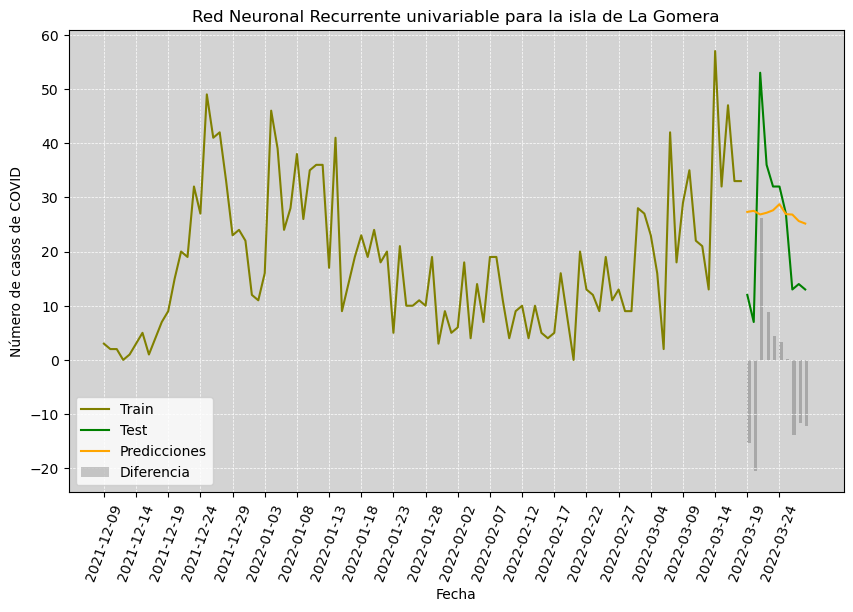

In [15]:
datos_train = datos_LaGomera_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',n_dias_train_vis,fechas,tit,color_isla,dif)

In [16]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 192.1633723486284
Error absoluto medio (MAE) del modelo: 11.617336463928222
Raíz del error cuadrático medio (RMSE) del modelo: 13.862300398874222


# Red Neuronal Recurrente multivariable con variables de pandemia

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_mult_covid_scaled = scaler.fit_transform(datos_LaGomera_mult_covid)


# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_LaGomera_mult_covid[objetivo]).reshape(-1, 1))

In [18]:
n_train = len(datos_LaGomera_mult_covid_scaled) - dias_prediccion


train = datos_LaGomera_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaGomera_mult_covid_scaled[n_train - dias_prediccion:len(datos_LaGomera_mult_covid_scaled), :]

In [19]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [20]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0417 - val_loss: 0.1727 - 3s/epoch - 215ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0354 - val_loss: 0.1273 - 134ms/epoch - 10ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0308 - val_loss: 0.1046 - 131ms/epoch - 9ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0262 - val_loss: 0.0747 - 130ms/epoch - 9ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0211 - val_loss: 0.0614 - 133ms/epoch - 9ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0195 - val_loss: 0.0625 - 131ms/epoch - 9ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0183 - val_loss: 0.0634 - 132ms/epoch - 9ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0190 - val_loss: 0.0617 - 130ms/epoch - 9ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0189 - val_loss: 0.0594 - 132ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0169 - val_loss: 0.0648 - 132ms/epoch - 9ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0162 - val_loss: 0.0587 - 131ms/epoch - 9ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0145 - val_loss: 0.0859 - 129ms/epoch - 9ms/step
Epoch 13/40
14/14 - 0s - 

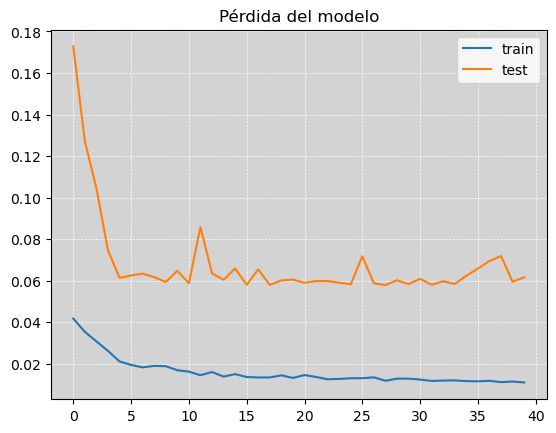

In [21]:
visualizar_perdida(historico)

In [22]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 286ms/step


In [23]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 12, número de casos predichos 27.849047
2022-03-20: número de casos reales 7, número de casos predichos 27.965725
2022-03-21: número de casos reales 53, número de casos predichos 27.200544
2022-03-22: número de casos reales 36, número de casos predichos 27.42158
2022-03-23: número de casos reales 32, número de casos predichos 27.89922
2022-03-24: número de casos reales 32, número de casos predichos 28.942886
2022-03-25: número de casos reales 27, número de casos predichos 27.653633
2022-03-26: número de casos reales 13, número de casos predichos 27.294823
2022-03-27: número de casos reales 14, número de casos predichos 26.127855
2022-03-28: número de casos reales 13, número de casos predichos 25.426962


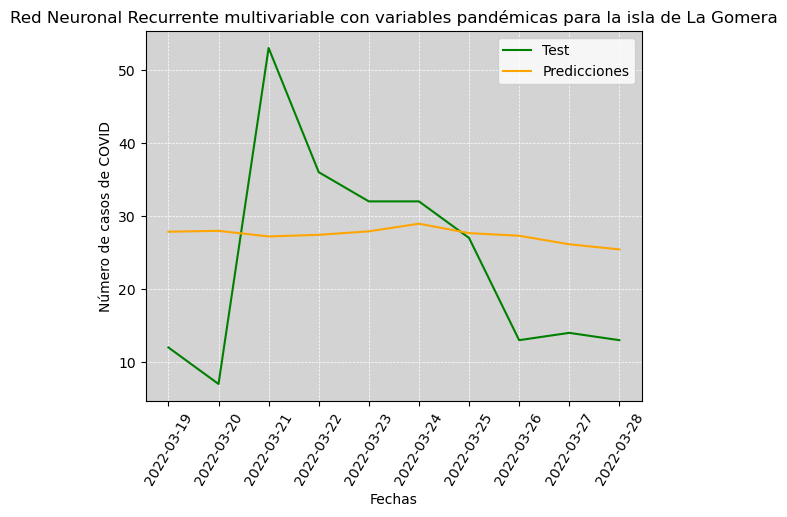

In [24]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [25]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-15.84904671, -20.96572495,  25.79945564,   8.57842064,
         4.10078049,   3.05711365,  -0.65363312, -14.29482269,
       -12.1278553 , -12.4269619 ])

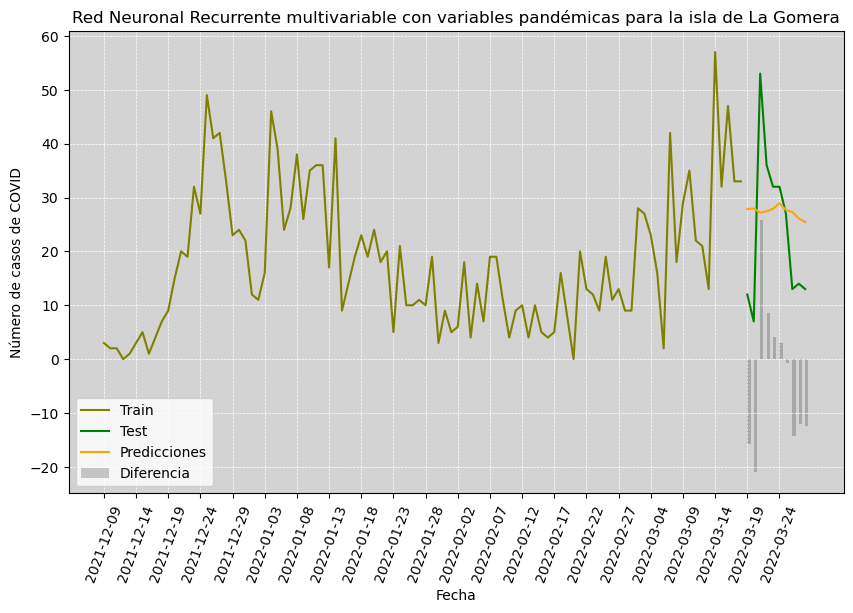

In [26]:
datos_train = datos_LaGomera_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [27]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 196.240090888138
Error absoluto medio (MAE) del modelo: 11.785381507873534
Raíz del error cuadrático medio (RMSE) del modelo: 14.008572050288995


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_mult_atm_scaled = scaler.fit_transform(datos_LaGomera_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_LaGomera_mult_atm[objetivo]).reshape(-1, 1))

In [29]:
n_train = len(datos_LaGomera_mult_atm_scaled) - dias_prediccion


train = datos_LaGomera_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaGomera_mult_atm_scaled[n_train - dias_prediccion:len(datos_LaGomera_mult_atm_scaled), :]

In [30]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [31]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0462 - val_loss: 0.1604 - 3s/epoch - 208ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0403 - val_loss: 0.1271 - 130ms/epoch - 9ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0350 - val_loss: 0.0942 - 127ms/epoch - 9ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0293 - val_loss: 0.0695 - 126ms/epoch - 9ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0278 - val_loss: 0.0683 - 126ms/epoch - 9ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0266 - val_loss: 0.0675 - 127ms/epoch - 9ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0242 - val_loss: 0.0665 - 127ms/epoch - 9ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0227 - val_loss: 0.0710 - 130ms/epoch - 9ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0222 - val_loss: 0.0647 - 125ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0228 - val_loss: 0.0640 - 126ms/epoch - 9ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0199 - val_loss: 0.0671 - 126ms/epoch - 9ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0197 - val_loss: 0.0644 - 127ms/epoch - 9ms/step
Epoch 13/40
14/14 - 0s - l

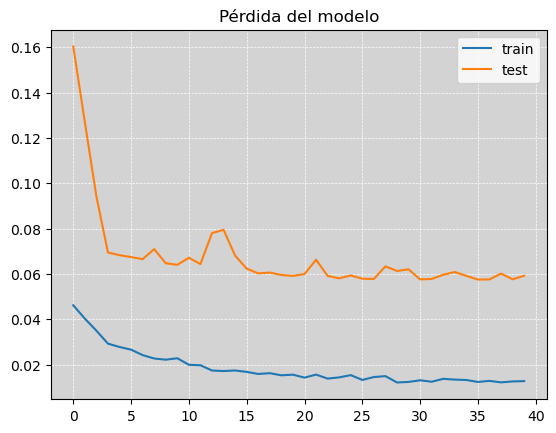

In [32]:
visualizar_perdida(historico)

In [33]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 471ms/step


In [34]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 12, número de casos predichos 26.472046
2022-03-20: número de casos reales 7, número de casos predichos 26.679468
2022-03-21: número de casos reales 53, número de casos predichos 26.193499
2022-03-22: número de casos reales 36, número de casos predichos 26.445
2022-03-23: número de casos reales 32, número de casos predichos 26.780197
2022-03-24: número de casos reales 32, número de casos predichos 27.60847
2022-03-25: número de casos reales 27, número de casos predichos 26.338625
2022-03-26: número de casos reales 13, número de casos predichos 26.201986
2022-03-27: número de casos reales 14, número de casos predichos 25.078426
2022-03-28: número de casos reales 13, número de casos predichos 24.506905


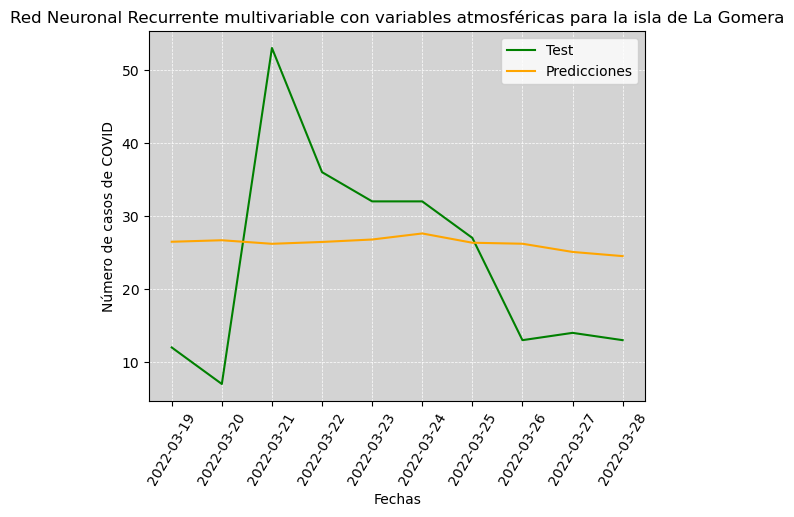

In [35]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [36]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-14.4720459 , -19.67946815,  26.80650139,   9.55500031,
         5.21980286,   4.39152908,   0.66137505, -13.20198631,
       -11.07842636, -11.5069046 ])

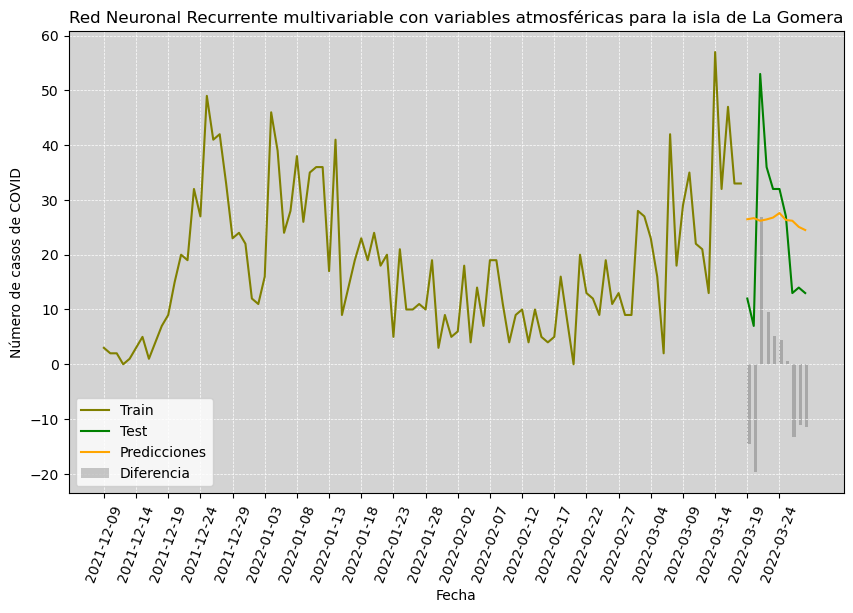

In [37]:
datos_train = datos_LaGomera_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [38]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 188.3010240136864
Error absoluto medio (MAE) del modelo: 11.657304000854491
Raíz del error cuadrático medio (RMSE) del modelo: 13.722282026459244


# Red Neuronal Recurrente multivariable con todas las variables

In [39]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_mult_total_scaled = scaler.fit_transform(datos_LaGomera_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_LaGomera_mult_total[objetivo]).reshape(-1, 1))

In [40]:
n_train = len(datos_LaGomera_mult_total_scaled) - dias_prediccion


train = datos_LaGomera_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaGomera_mult_total_scaled[n_train - dias_prediccion:len(datos_LaGomera_mult_total_scaled), :]

In [41]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [42]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0454 - val_loss: 0.1789 - 3s/epoch - 209ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0388 - val_loss: 0.1391 - 162ms/epoch - 12ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0339 - val_loss: 0.0942 - 156ms/epoch - 11ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0287 - val_loss: 0.0805 - 156ms/epoch - 11ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0230 - val_loss: 0.0654 - 156ms/epoch - 11ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0237 - val_loss: 0.0648 - 156ms/epoch - 11ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0223 - val_loss: 0.0646 - 156ms/epoch - 11ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0212 - val_loss: 0.0641 - 157ms/epoch - 11ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0193 - val_loss: 0.0757 - 158ms/epoch - 11ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0212 - val_loss: 0.0633 - 156ms/epoch - 11ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0196 - val_loss: 0.0650 - 155ms/epoch - 11ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0180 - val_loss: 0.0627 - 157ms/epoch - 11ms/step
Epoch 13/40
14/

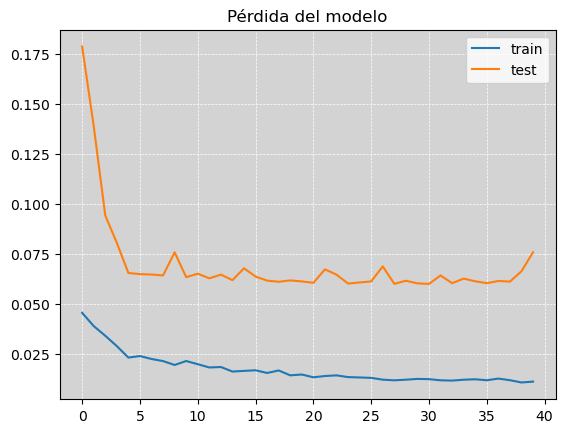

In [43]:
visualizar_perdida(historico)

In [44]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 286ms/step


In [45]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 12, número de casos predichos 31.722727
2022-03-20: número de casos reales 7, número de casos predichos 31.627455
2022-03-21: número de casos reales 53, número de casos predichos 30.812546
2022-03-22: número de casos reales 36, número de casos predichos 30.841274
2022-03-23: número de casos reales 32, número de casos predichos 31.259808
2022-03-24: número de casos reales 32, número de casos predichos 32.203327
2022-03-25: número de casos reales 27, número de casos predichos 31.76368
2022-03-26: número de casos reales 13, número de casos predichos 31.605402
2022-03-27: número de casos reales 14, número de casos predichos 30.32166
2022-03-28: número de casos reales 13, número de casos predichos 29.319197


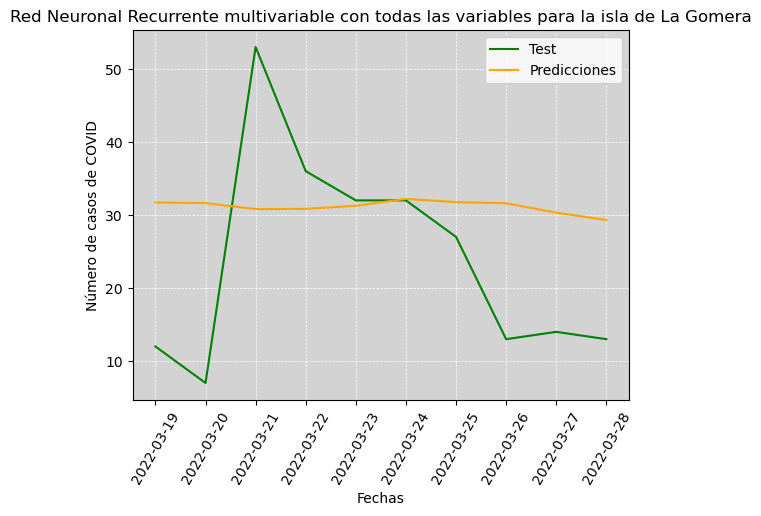

In [46]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [47]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-19.72272682, -24.62745476,  22.18745422,   5.15872574,
         0.74019241,  -0.20332718,  -4.7636795 , -18.60540199,
       -16.32165909, -16.3191967 ])

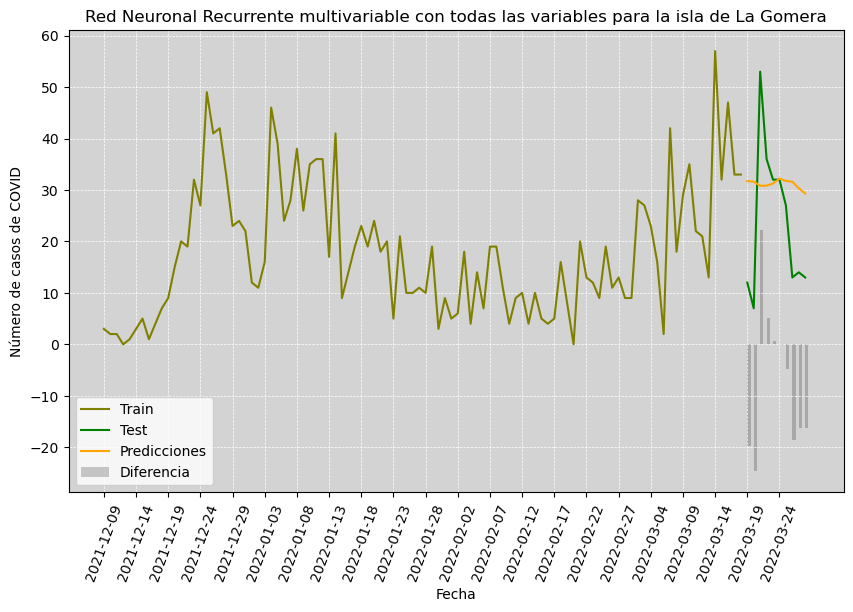

In [48]:
datos_train = datos_LaGomera_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [49]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 241.65486461459804
Error absoluto medio (MAE) del modelo: 12.864981842041015
Raíz del error cuadrático medio (RMSE) del modelo: 15.545252156674655
